In [8]:
import time
import torch
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Add project root to PYTHONPATH
sys.path.append('/home/vkapil/scratch/nl/torch-nlpp')

from ase import Atoms
from neighbourlist import NeighbourList
from vesin import ase_neighbor_list
from vesin import NeighborList as NeighbourList_vesin
from torch_nl import compute_neighborlist_n2, ase2data

In [9]:


plt.rcParams.update({
    'lines.markersize': 4,
    'lines.linewidth': 1.5,  # Increased from 1 to 1.5
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
})

colors = sns.color_palette("deep")

In [2]:
def time_fn(fn, n_tries=10, sync_cuda=False):
    # warmup
    for _ in range(1):
        fn()
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()

    start = time.perf_counter()
    for _ in range(n_tries):
        fn()
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()
    return (time.perf_counter() - start) / n_tries * 1000.0  # ms

In [3]:
cell = [
    [2.460394, 0.0, 0.0],
    [-1.26336, 2.044166, 0.0],
    [-0.139209, -0.407369, 6.809714],
]

positions = [
    [-0.03480225, -0.10184225, 1.70242850],
    [-0.10440675, -0.30552675, 5.10728550],
    [-0.05691216,  1.26093576, 1.70242850],
    [ 1.11473716,  0.37586124, 5.10728550],
]

base = Atoms(
    symbols="CCCC",
    positions=positions,
    cell=cell,
    pbc=True,
)

In [4]:

supercells = [1, 2, 4, 6, 8, 10 ]      # (n,n,n) replication
radii = [3.0, 4.5, 6.0]
n_tries = 1

device = "cuda:0" 

In [5]:
results = {}   # radius → num_atoms → timings dict

for radius in radii:
    print("\n" + "=" * 80)
    print(f"radius = {radius}")
    print("=" * 80)

    results[radius] = {}

    for n in supercells:

        carbon = base * (n, n, n)
        num_atoms = len(carbon)
        print(f"\nSupercell size: ({n}, {n}, {n})  →  num_atoms = {num_atoms}")

        results[radius][num_atoms] = {}

        # --- VK NeighbourList (O(N^2), no compile) ---
        nl = NeighbourList(
            list_of_configurations=[carbon],
            radius=radius,
            batch_size=1,
            device=device,
        )
        nl.load_data()

        def vk_nl_no_compile():
            _ = nl.calculate_neighbourlist(use_torch_compile=False)

        t_vk_no_compile = time_fn(vk_nl_no_compile, n_tries=n_tries, sync_cuda=True)
        results[radius][num_atoms]["vk_no_compile"] = t_vk_no_compile

        # --- VK NeighbourList (O(N^2), compile=True) ---
        def vk_nl_compile():
            _ = nl.calculate_neighbourlist(use_torch_compile=True)

        t_vk_compile = time_fn(vk_nl_compile, n_tries=n_tries, sync_cuda=True)
        results[radius][num_atoms]["vk_compile"] = t_vk_compile

        # --- ASE neighbour list (O(N)) ---
        def ase_nl():
            i, j, S, d = ase_neighbor_list("ijSd", carbon, cutoff=radius)

        t_ase = time_fn(ase_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][num_atoms]["ase"] = t_ase

        # --- vesin neighbour list (O(N)) ---
        def vesin_nl():
            calculator = NeighbourList_vesin(cutoff=radius, full_list=True)
            i, j, S, d = calculator.compute(
                points=carbon.positions,
                box=carbon.cell,
                periodic=True,
                quantities="ijSd",
            )

        t_vesin = time_fn(vesin_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][num_atoms]["vesin"] = t_vesin

        # --- torch-nl O(N^2) ---
        pos, cell_t, pbc, batch, _ = ase2data([carbon])

        def torch_nl_n2():
            compute_neighborlist_n2(radius, pos, cell_t, pbc, batch, False)

        compute_neighborlist_n2(radius, pos, cell_t, pbc, batch, False)  # warmup

        t_torch_n2 = time_fn(torch_nl_n2, n_tries=n_tries, sync_cuda=False)
        results[radius][num_atoms]["torch_n2"] = t_torch_n2

        # print summary for immediate visibility
        print(f"  VK O(N^2) (no compile)     : {t_vk_no_compile:8.3f} ms")
        print(f"  VK O(N^2) (compile=True)   : {t_vk_compile:8.3f} ms")
        print(f"  ASE O(N)                   : {t_ase:8.3f} ms")
        print(f"  vesin O(N)                 : {t_vesin:8.3f} ms")
        print(f"  torch-nl O(N^2)            : {t_torch_n2:8.3f} ms")



radius = 3.0

Supercell size: (1, 1, 1)  →  num_atoms = 4


/home/vkapil/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:718: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/vkapil/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:718: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/vkapil/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:718: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


  VK O(N^2) (no compile)     :    0.901 ms
  VK O(N^2) (compile=True)   :    0.680 ms
  ASE O(N)                   :    0.068 ms
  vesin O(N)                 :    0.043 ms
  torch-nl O(N^2)            :    0.537 ms

Supercell size: (2, 2, 2)  →  num_atoms = 32
  VK O(N^2) (no compile)     :    0.589 ms
  VK O(N^2) (compile=True)   :    1.007 ms
  ASE O(N)                   :    0.112 ms
  vesin O(N)                 :    0.072 ms
  torch-nl O(N^2)            :    1.599 ms

Supercell size: (4, 4, 4)  →  num_atoms = 256
  VK O(N^2) (no compile)     :    0.733 ms
  VK O(N^2) (compile=True)   :    0.516 ms
  ASE O(N)                   :    0.617 ms
  vesin O(N)                 :    0.409 ms
  torch-nl O(N^2)            :   69.013 ms

Supercell size: (6, 6, 6)  →  num_atoms = 864
  VK O(N^2) (no compile)     :    2.945 ms
  VK O(N^2) (compile=True)   :    0.864 ms
  ASE O(N)                   :    1.700 ms
  vesin O(N)                 :    0.930 ms
  torch-nl O(N^2)            :  886.700 ms


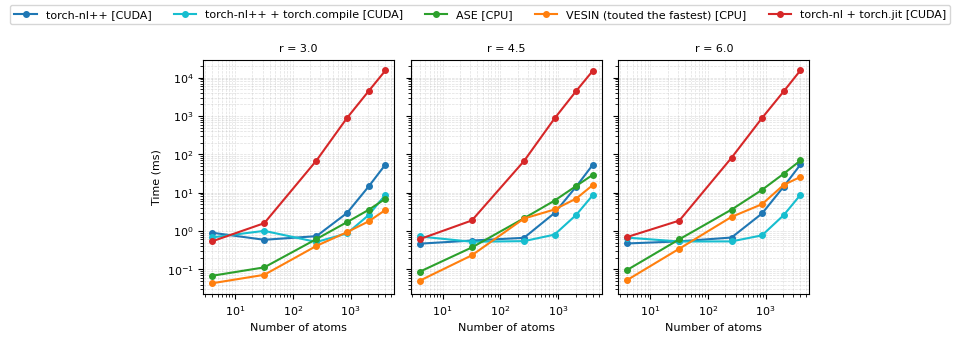

In [ ]:
import matplotlib.pyplot as plt

methods = ["vk_no_compile", "vk_compile", "ase", "vesin", "torch_n2"]

labels = ['torch-nl++ [CUDA]', 'torch-nl++ + torch.compile [CUDA]', 'ASE [CPU]', 'VESIN (touted the fastest) [CPU]', 'torch-nl + torch.jit [CUDA]' ]
colors = {
    "vk_no_compile": "tab:blue",
    "vk_compile":    "tab:cyan",
    "ase":           "tab:green",
    "vesin":         "tab:orange",
    "torch_n2":      "tab:red",
}

radii_list = list(results.keys())
num_panels = len(radii_list)

fig, axes = plt.subplots(1, num_panels, sharex=True, sharey=True, figsize=(3.41 * 2, 3.41))

# If only one radius, axes is not iterable
if num_panels == 1:
    axes = [axes]

for ax, radius in zip(axes, radii_list):

    num_atoms_list = sorted(results[radius].keys())

    for method, label in zip(methods, labels):
        times = [results[radius][N][method] for N in num_atoms_list]
        ax.plot(num_atoms_list, times, marker='o',
                color=colors[method],
                label=label)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"r = {radius}")
    ax.grid(True, which="both", ls="--", alpha=0.4)

axes[0].set_xlabel("Number of atoms")
axes[1].set_xlabel("Number of atoms")
axes[2].set_xlabel("Number of atoms")

axes[0].set_ylabel("Time (ms)")

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(methods))

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
